## Convective/Stratiform Separation Masking for derived 3D dBZ of WRF Simulations. 

**Directly use $\sigma$ level instead of interpolation to certain height.**

**For [High Resolution WRF Simulations of the Current and Future Climate of North America](https://rda.ucar.edu/datasets/ds612.0/).**

**Hungjui Yu 20211013**

In [46]:
import sys
from shutil import copyfile
import time
import datetime as dt
import pytz
from netCDF4 import (Dataset, MFDataset)
import numpy as np
from scipy.interpolate import interpn
import xarray as xr
import pandas as pd
import wrf
from wrf import (getvar, vinterp, interplevel, extract_times, destagger, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib as mpl
import matplotlib.pyplot as plt

import wrf_convstrat as sep0
import conv_strat_latlon as sep1
import conv_stra_sep as sep2

**Set input files paths and names:**

In [47]:
def set_input_names(file_date):

    file_path_1 = '/gpfs/fs1/collections/rda/data/ds612.0'
    file_path_1_dbz = '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0'
    file_path_2 = '/' + wrf_sim_type # '/CTRL3D'
    file_path_3 = '/{}'.format(file_date.strftime('%Y'))

    file_names = dict( dbz = file_path_1_dbz
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_dbz_{}.nc'.format(file_date.strftime('%Y%m%d'))
                       , Z = file_path_1 
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_Z_{}.nc'.format(file_date.strftime('%Y%m%d'))
                     )
    
    return file_names

In [48]:
## Set wrf simulation type:
wrf_sim_type = 'CTRL3D'

## Set date time:
# case_date_time = dt.datetime(2011,4,27) 
case_date_time = dt.datetime(2013,9,13) 

file_name_list = set_input_names(case_date_time)
print(file_name_list)

{'dbz': '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0/CTRL3D/2013/wrf3d_d01_CTRL_dbz_20130913.nc', 'Z': '/gpfs/fs1/collections/rda/data/ds612.0/CTRL3D/2013/wrf3d_d01_CTRL_Z_20130913.nc'}


**Open data directly:**

In [49]:
## Set hour:
## 0:00, 1:03, 2:06, 3:09, 4:12, 5:15, 6:18, 7:21
time_hour_idx = 0

## Set sigma level index:
interp_vertical_lev = 12 # number in levels.

## Get dBZ and the geopotential height:
ds_wrf_dbz = xr.open_dataset(file_name_list['dbz'])
da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=time_hour_idx)

data_wrf_z_unstag = wrf.destagger(getvar(Dataset(file_name_list['Z']), 'Z', timeidx=time_hour_idx, meta=False), 0)


dbz_sigmalev = da_wrf_dbz[interp_vertical_lev,:,:]
geoH_sigmalev = data_wrf_z_unstag[interp_vertical_lev,:,:]


**Convective/Stratiform separation:**

In [50]:
## Make sure the array for the masking is in numpy array format (speed issue):
refl = dbz_sigmalev.data
lat = np.array(dbz_sigmalev.XLAT)
lon = np.array(dbz_sigmalev.XLONG)

print(type(refl))

start = time.time()

## Convective/Stratiform separation:
# cs, cc, bkgnd = sep0.conv_strat_latlon(refl, lat, lon)
cs, cc, bkgnd = sep2.conv_stra_sep(refl, lat, lon)

# cs, cc, bkgnd = sep2.conv_stra_sep(dbz_lev.data, dbz_lev.XLAT, dbz_lev.XLONG)

end = time.time()
print("RUNTIME：%f SEC" % (end - start))
print("RUNTIME：%f MIN" % ((end - start)/60))
print("RUNTIME：%f HOUR" % ((end - start)/3600))

<class 'numpy.ndarray'>
RUNTIME：6.510337 SEC
RUNTIME：0.108506 MIN
RUNTIME：0.001808 HOUR


In [51]:
# xcs = xr.DataArray(cs)
# xdbz = xr.DataArray(refl)
# xdbz.plot()
# print(type(np.array(dbz_lev.XLAT)))
# print(type(dbz_lev.XLAT))
# np.argwhere(np.isnan(dbz_lev.data))

**Filter the Conv/Stra class by Reflectivity:**

In [52]:
# cs[np.where(refl <= -30.0)] = np.nan
# cs[np.where(refl <= -20.0)] = np.nan
cs[np.where(refl <= 0.0)] = np.nan
cs[np.where(np.isnan(refl))] = -1

# cs

**Save interpolated field to temporary file (if needed):**

In [53]:
# dbz_lev.to_netcdf('/glade/scratch/hungjui/temp/tmp_dbz_lev.nc')
# write_xarray_to_netcdf(dbz_lev, '/glade/scratch/hungjui/temp/tmp_dbz_lev.nc')

### Test plot:

**Function: creating new map:**

In [54]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal()
    proj = ccrs.PlateCarree(central_longitude=0)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Set extent:
    # ax.set_global()
    # ax.set_extent([-139, -55, 16, 60], crs=proj)
    # ax.set_extent([-100, -84, 32, 41], crs=proj)
    ax.set_extent([-115, -95, 32, 45], crs=proj)
    
    ## Add coast lines:
    ax.coastlines('10m', 'black', linewidth=1)
    
    ## Add features:
    ax.add_feature(cfeat.BORDERS)
    ax.add_feature(cfeat.OCEAN, edgecolor=None, fc='none')
    
    ## Grab state shapefile:
    state_borders = cfeat.NaturalEarthFeature(category='cultural', 
                                              name='admin_1_states_provinces_lines', 
                                              scale='110m', 
                                              facecolor='none',
                                              edgecolor='k'
                                             )
    
    ax.add_feature(state_borders, linewidth=0.8)
    
    ## Add the gridlines:
    latlon_grid_int = 2
    ax_gl = ax.gridlines(crs=ccrs.PlateCarree()
                        ,linewidth=0.5
                        ,color='#454545' 
                        ,alpha=0.9
                        ,linestyle='--'
                        ,draw_labels=True 
                        ,dms=True
                        ,x_inline=False 
                        ,y_inline=False
                        ,xlocs=np.arange(-180, 181, latlon_grid_int)
                        ,ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 12, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 12, 'weight': 'bold'}
    
    
    return ax

**Do the plot:**

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


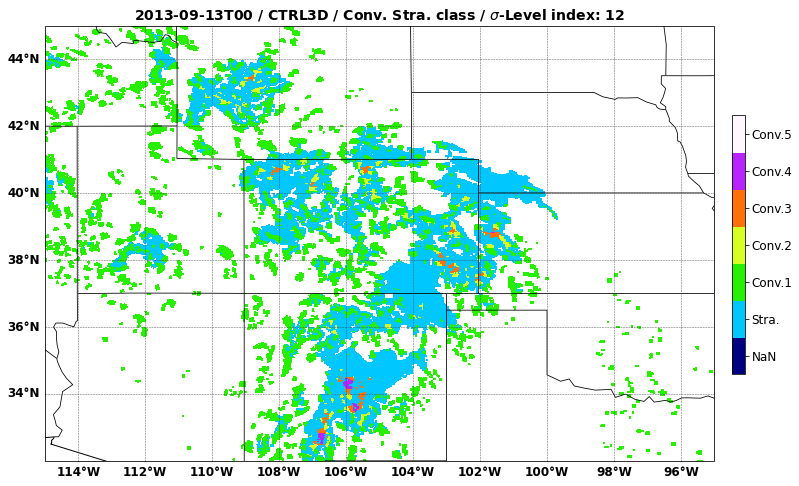

In [55]:
fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

# cs[cs<0] = np.nan
# cc[cc<0] = np.nan

plotting_var = cs
plotting_lon = dbz_sigmalev.XLONG
plotting_lat = dbz_sigmalev.XLAT

cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
                    , cmap=plt.cm.get_cmap('gist_ncar', 7)
                    , vmin=-1
                    , vmax=5
                    , shading='auto'
                    )
cf1.cmap.set_under('w')

## Title:
cf1_title = plt.title( np.datetime_as_string(dbz_sigmalev.Time.data, unit='h') + ' / '
                     + wrf_sim_type + ' / '
                     + 'Conv. Stra. class / '
                     + '$\sigma$-Level index: ' + str(interp_vertical_lev)
                     ,fontsize=14 
                     ,fontweight='bold'
                     # ,loc='left'
                     )
# plt.title('right', loc='right')

## Colorbar:
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(cf1, 
                    cax=cbar_ax, 
                    fraction=0.04, 
                    ticks=np.arange(-1, 6, 1), 
                    boundaries=np.arange(-1.5, 6.5, 1))
cbar.ax.tick_params(labelsize=12)
cbar.set_ticklabels(['NaN', 'Stra.', 'Conv.1', 'Conv.2', 'Conv.3', 'Conv.4', 'Conv.5'])
# cbar_title = plt.title('[dBZ]', fontsize=12, y=-0.1)

## Save figure:
plt.savefig('./' + np.datetime_as_string(dbz_sigmalev.Time.data, unit='h') + '_CSmask_sigma.png', 
            bbox_inches='tight', 
            dpi=300)


In [56]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
